## Esame Metodi Numerici  10 gennaio 2025 - Ore 14

Si considerino i due sistemi lineari:

     A  x = b 

    A1 x1 = b1

dove A, A1 sono le matrici dei coefficienti, b e b1 sono i termini noti, ed x ed x1 sono i vettori incogniti da determinare.
I dati di questi due sistemi lineari sono contenuti nel file **test.mat**.


- Si risolva ciascuno dei sistemi lineari assegnati  utilizzato il metodo più adatto in base alle caratteristiche della matrice dei coefficienti, giustificando teoricamente le scelte effettuate.
                                      **punti 5**

Per il primo sistema lineare A x= b,  aggiungere una perturbazione dell' 1% sulla componente b[0]  del termine noto, e risolvere il sistema con termine noto perturbato. Calcolare quindi  l'errore relativo sulla soluzione e l'errore relativo sui dati e giustificare i risultati alla luce della teoria, richiamando il teorema relativo.
                                      **punti 3**


Per la lettura dei dati procedere nel seguente modo:

``from scipy.io import loadmat``

``import numpy as np``

``dati = loadmat('test')``

``A=dati["A"] ``

``A=A.astype(float)``

`` b=dati["b"] ``

`` b=b.astype(float)``

``A1=dati["A1"] ``

``A1=A1.astype(float)``

`` b1=dati["b1"] ``

`` b1=b1.astype(float)``

 

In [12]:
from scipy.io import loadmat
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from SolveTriangular import Lsolve, Usolve

dati = loadmat('test')
A=dati["A"] 
A=A.astype(float)
b=dati["b"]
b=b.astype(float) 

A1=dati["A1"] 
A1=A1.astype(float)
b1=dati["b1"]
b1=b1.astype(float)

def print_dim(matName, mat):
    print(f"Dimensioni {matName}: {mat.shape} — (righe, colonne)")
    
print_dim("A", A)
print_dim("A1", A1)

# La prima matrice è quadrata e di piccole dimensioni => metodi diretti
# La seconda matrice non è quadrata => sistema sovradeterminato (eq. normali, qrLS, svdLS)

# Occupiamoci della prima matrice
# Abbiamo 3 possibili metodi:
# — Fattorizzazione Householder QR
# — Fattorizzazione Cholesky L·Lt (o Rt·R)
# — Fattorizzazione Gauss LU

# Proviamo a vedere se A è simmetrica e definita positiva
def is_symm(A):
    return np.allclose(A, A.T, atol=np.spacing(1))

def is_def_pos(A):
    return is_symm(A) and np.all(np.linalg.eigvals(A) > 0)

print("A è simmetrica e definita positiva?", is_def_pos(A))
# A è simmetrica e definita positiva! Possiamo applicare la scomposizione di Cholesky

def solve_cholesky(A, b):
    L = sc.linalg.cholesky(A, lower=True)
    Lt = L.T
    # Ax = b => L·Lt·x = b
    # A sistema abbiamo:
    # L·y = b
    # Lt·x = y
    y, flag = Lsolve(L, b) 
    if flag == 0:
        x, flag = Usolve(Lt, y)
        return x

# solve_cholesky(A, b)
x_corr = sc.linalg.cho_solve(sc.linalg.cho_factor(A), b)

# Proviamo a perturbare b[0] dell'1%
b_pert = b.copy()
b_pert[0] += b_pert[0] * .01
x_pert = sc.linalg.cho_solve(sc.linalg.cho_factor(A), b_pert)

error_res = np.linalg.norm(x_pert - x_corr) / np.linalg.norm(x_corr)

print("Errore sui risultati con perturbazione dell'1% sui dati iniziali: ", error_res)
# A fronte di una perturbazione dell 1% su una piccola parte dei
# dati iniziali del problema otteniamo una perturbazione del 10% sui risultati

# Problema ben condizionato

Dimensioni A: (20, 20) — (righe, colonne)
Dimensioni A1: (20, 15) — (righe, colonne)
A è simmetrica e definita positiva? True
Errore sui risultati con perturbazione dell'1% sui dati iniziali:  0.10723161946428181


In [13]:
# Passiamo ora alla seconda matrice: abbiamo un sistema sovradeterminato da risolvere
# Controlliamo il rango della matrice
k = np.linalg.matrix_rank(A1)
m, n = A1.shape
condA1 = np.linalg.cond(A1)
print("Rango di A1:", k)
print("A1 ha rango massimo?", n == k) # Non a rango massimo!
print("Condizionamento A1:", condA1) # Altamente malcondizionata!

# Questo ci suggerisce che, tra i 3 metodi a nostra disposizione, dobbiamo ricorrere alla 
# Single Value Decomposition Least Squares (svdLS)

def svdLS(A, b):
    m, n = A.shape
    U, s, Vt = sc.linalg.svd(A)
    V = Vt.T
    threshold = s[0] * m * np.spacing(1)
    rk_A = np.count_nonzero(s > threshold)
    d = U.T @ b
    d1 = d[:rk_A].reshape(rk_A, 1)
    s1 = s[:rk_A].reshape(rk_A, 1)
    c = d1 / s1
    x = V[:, :rk_A] @ c
    residuo = np.linalg.norm(d[rk_A:]) ** 2
    return x, residuo

svdLS(A1, b1.reshape((m,)))

Rango di A1: 13
A1 ha rango massimo? False
Condizionamento A1: 5.4550631866614824e+16


(array([[0.5210993 ],
        [1.25827182],
        [1.27889527],
        [0.46087355],
        [0.89024294],
        [1.04762977],
        [0.29616227],
        [0.59585228],
        [1.13383321],
        [0.94430646],
        [1.32127485],
        [0.97301581],
        [0.15568769],
        [0.79644108],
        [1.09968922]]),
 6.803925307531227e-30)


- Dato il sistema lineare 
A3 x3 = b3
dove 

A3=np.array([[8,0,1],[0,12,2],[1,2,-14.0]])
b3= np.array([9.0, 14.0,  -11.0])

- Verificare senza calcolare il raggio spettrale della matrice di iterazione che il metodo di Gauss-Seidel converge, richiamando il teorema che garantisce la convergenza di Gauss-Seidel per classi particolari di 
matrici     **punti[1]**.
- Implementare il metodo di Gauss-Seidel  e risolvere il sistema lineare A3 x3= b3 con  **punti[3]**.

Totale **Punti 12**

In [40]:
A3 = np.array([
    [8,0,1],
    [0,12,2],
    [1,2,-14.0]
])
b3 = np.array([9.0, 14.0, -11.0])

def is_dd(A):
    d = np.diag(np.abs(A))
    row_sum = np.sum(np.abs(A), axis=1)
    return np.all(d > row_sum - d)

print(is_dd(A3))

def gauss_seidel(A, b, x0, maxit, toll=np.spacing(1)):
    d = np.diag(A)
    L = np.tril(A, k=-1)
    U = np.triu(A, k=1)
    D = np.diag(d)

    M = U + D
    N = -L

    # Ax = b
    # Mx - Nx = b
    # Mx = Nx + b
    # --> x = M^-1·N·x + M^-1·b
    T = np.linalg.inv(M) @ N
    q = np.linalg.inv(M) @ b

    x_next, x_curr = None, x0
    attempts = [ x_curr ]
    while len(attempts) < maxit:
        x_next = T @ x_curr + q
        attempts.append(x_next)
        error_x = np.linalg.norm(x_next - x_curr) / (np.linalg.norm(x_curr) if np.linalg.norm(x_curr) != 0 else 1)
        if error_x < toll:
            break
        else:
            x_curr = x_next
    
    return attempts[-1], attempts

x0 = np.zeros(A3.shape[1])
gauss_seidel(A3, b3, x0, 10_000)

True


(array([1., 1., 1.]),
 [array([0., 0., 0.]),
  array([1.02678571, 1.03571429, 0.78571429]),
  array([0.99912309, 0.99883078, 1.00701531]),
  array([1.00002871, 1.00003828, 0.99977033]),
  array([0.99999906, 0.99999875, 1.00000752]),
  array([1.00000003, 1.00000004, 0.99999975]),
  array([1.        , 1.        , 1.00000001]),
  array([1., 1., 1.]),
  array([1., 1., 1.]),
  array([1., 1., 1.]),
  array([1., 1., 1.]),
  array([1., 1., 1.]),
  array([1., 1., 1.])])

# Esercizio 2

Implementare le function necessarie per costruire il polinomio interpolante di Lagrange. 
                                       **[4 punti]**
                                                         

In [9]:
def plagr(xnodi, j):
    xzeri = np.zeros_like(xnodi)
    n = xnodi.size
    
    if j == 0:
        xzeri = xnodi[1:n]
    else:
        xzeri = np.append(xnodi[0:j], xnodi[j+1:n])

    num=np.poly(xzeri) #Calcola i coefficienti del polinomio di grado n che si annulla nel vettore xzeri
    den=np.polyval(num,xnodi[j]) #Lo valuta nel nodo escluso (-jesimo)
    
    p=num/den
    
    return p

def interpL(x, y, xx):
    n = x.size
    m = xx.size
    L = np.zeros((m, n))
    for i in range(n):
        p = plagr(x, i)
        L[:,i] = np.polyval(p, xx)
    return L @ y

Sia assegnata la funzione $f(x)=cos(\pi x)+sin(\pi x)$, $ x \in [0,2]$,
facendo uso delle functions implementate precedentemente, si determini il polinomio p che interpola f nei nodi  x0 = 1, x1 = 1.5, x2 = 1.75 e si rappresenti in uno stesso grafico la funzione f, il polinomio p e i punti di interpolazione assegnati;
                                          **[2 punti]**

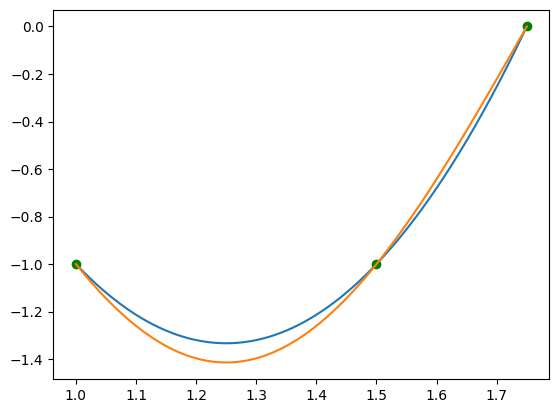

In [21]:
import math
f = lambda x: np.cos(math.pi * x) + np.sin(math.pi * x)
p1 = (1, f(1))
p2 = (1.5, f(1.5))
p3 = (1.75, f(1.75))
points = [ p1, p2, p3 ]

xx = np.linspace(1, 1.75, 1000)
pol = interpL(
    np.array([p[0] for p in points]),
    np.array([p[1] for p in points]),
    xx)

plt.plot(xx, pol, 
         p1[0], p1[1], "go", 
         p2[0], p2[1], "go", 
         p3[0], p3[1], "go",
        xx, f(xx))
plt.show()

 si calcoli il valore assunto dalla funzione errore E(x) := |f(x) − p(x)| nel punto $x^∗$ = 0.75 e si definisca teoricamente da cosa dipende l'errore che si compie quando al posto del polinomio interpolatore si considera la funzione che ha generato i dati, commentando opportunamente la formula 
                                                             **[3 punti]**

In [24]:
error_fn = lambda x: np.abs(f(x) - pol(x))


[-1.00000000e+00 -1.00199900e+00 -1.00399198e+00 -1.00597895e+00
 -1.00795991e+00 -1.00993486e+00 -1.01190380e+00 -1.01386672e+00
 -1.01582363e+00 -1.01777453e+00 -1.01971942e+00 -1.02165829e+00
 -1.02359116e+00 -1.02551801e+00 -1.02743885e+00 -1.02935368e+00
 -1.03126249e+00 -1.03316530e+00 -1.03506209e+00 -1.03695287e+00
 -1.03883764e+00 -1.04071639e+00 -1.04258914e+00 -1.04445587e+00
 -1.04631659e+00 -1.04817129e+00 -1.05001999e+00 -1.05186267e+00
 -1.05369934e+00 -1.05553000e+00 -1.05735465e+00 -1.05917329e+00
 -1.06098591e+00 -1.06279252e+00 -1.06459312e+00 -1.06638771e+00
 -1.06817628e+00 -1.06995885e+00 -1.07173540e+00 -1.07350594e+00
 -1.07527047e+00 -1.07702898e+00 -1.07878148e+00 -1.08052798e+00
 -1.08226845e+00 -1.08400292e+00 -1.08573138e+00 -1.08745382e+00
 -1.08917025e+00 -1.09088067e+00 -1.09258508e+00 -1.09428347e+00
 -1.09597586e+00 -1.09766223e+00 -1.09934259e+00 -1.10101693e+00
 -1.10268527e+00 -1.10434759e+00 -1.10600390e+00 -1.10765420e+00
 -1.10929849e+00 -1.11093

si stabilisca qual è il polinomio interpolatore per f passante per i nodi $x^*$ 
, x0, x1 e x2.   **[1 punto]**

Si calcoli la costante di Lebesgue per il problema di interpolazione in esame  e si dica che ruolo svolge nell'ambito dell'interpolazione polinomiale
                               **[3 punti]**

Totale **Punti 13**

## Domande Intelligenza Artificiale
**NB: Ogni risposta esatta:  +0.5 punti, ogni risposta errata: -0.5 punti. La mancanza di risposta:  0 punti**

**Risolvere un problema mediante Machine Learning significa**:
- Fornire alla macchina i dati affinchè impari da sola a risolvere il problema
- Fornire alla macchina solo dati etichettati affinchè impari da sola a risolvere il problema
- Fornire alla macchina solo dati non etichettati affinchè impari da sola a risolvere il problema
- Fornire alla macchina le esatte istruzioni per risolvere il problema
edizione

**2  A cosa serve il validation set?**

-  A trovare i migliori iperparametri del modello

-  Ad addestrare il modello

-  A testare il modello

-  A trovare le etichette dei dati di input

**3  Una classica rete CNN è solitamente composta da:**

· Layer convolutivi seguiti da layer di pooling, flatten layer e neuroni completamente connessi

· Layer di pooling seguiti da layer convolutivi, flatten layer e neuroni completamente connessi

· Layer convolutivi seguiti da layer di pooling, flatten layer e softmax

· Layer di pooling seguiti da layer convolutivi, flatten layer e softmax

**4 Il livello softmax**
- Trasforma i digits della rete in probabilità
- Trasforma le probabilità della rete in digits
- Normalizza i valori di input della rete
- È indispensabile nel task di regressione
lla rete

**5 Per una rete neurale, l’apprendimento è legato a:**
- 	Minimizzare la funzione obiettivo
- Minimizzare la funzione di attivazione
- 	Massimizzare il valore dei pesi tramite l’algoritmo di back-propagation
- Massimizzare il valore della funzione di training


**Domande Aperte**

**6. Spiega in modo dettagliato come il learning rate influenza la convergenza di una rete neurale durante il training. Quali sono le conseguenze di un learning rate troppo alto o troppo basso nel training di una rete neurale. Descrivi le principali strategie di  aggiornamentodel  learning rate durante il training di una rete neurale.** [punti 1.5]

**7. Descrivi in dettaglio l'algoritmo di discesa del gradiente con momento. Quali sono le motivazioni che hanno portato alla sua introduzione rispetto alla discesa del gradiente standard? Fornisci la formula matematica dell'aggiornamento dei pesi in questo algoritmo e spiega il ruolo del termine di momento** [punti 3]